<a href="https://www.kaggle.com/code/sudhanshu2198/techniques-for-imbalanced-classification-problems?scriptVersionId=111605460" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"]=(12,8)

# Data Summary

In [3]:
data=pd.read_csv("../input/microcalcification-classification/microcalcification.csv")

In [4]:
data.head()

,Area,Grey Level,Gradient Strength,Noise Fluctuation,Contrast,Shape Descriptor,Microcalcification
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,11183.0,1.096536e-10,1.0,-0.784415,-0.784415,-0.108577,0.313949,31.508443
Grey Level,11183.0,1.297595e-09,1.0,-0.470195,-0.470195,-0.394994,-0.076495,5.085849
Gradient Strength,11183.0,5.698113e-10,1.0,-0.591631,-0.591631,-0.230979,0.219837,29.477769
Noise Fluctuation,11183.0,-2.435706e-09,1.0,-0.859553,-0.859553,-0.859553,0.820208,9.591164
Contrast,11183.0,-1.120680e-09,1.0,-0.377866,-0.377866,-0.377866,-0.377866,23.617122
Shape Descriptor,11183.0,1.459483e-09,1.0,-0.945723,-0.945723,-0.945723,1.016613,1.949027


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11183 entries, 0 to 11182
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Area                11183 non-null  float64
 1   Grey Level          11183 non-null  float64
 2   Gradient Strength   11183 non-null  float64
 3   Noise Fluctuation   11183 non-null  float64
 4   Contrast            11183 non-null  float64
 5   Shape Descriptor    11183 non-null  float64
 6   Microcalcification  11183 non-null  object 
dtypes: float64(6), object(1)
memory usage: 611.7+ KB


# Exploratory Data Analysis

In [7]:
encoder=LabelEncoder()
data['Microcalcification']=encoder.fit_transform(data['Microcalcification'])

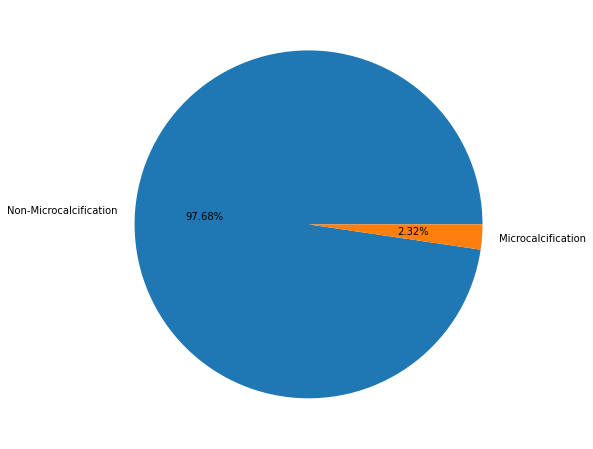

In [8]:
x=data['Microcalcification'].value_counts().to_list()
labels=['Non-Microcalcification','Microcalcification']

plt.pie(x,labels=labels,autopct='%1.2f%%',startangle=0);

Severely Skewed Class Distribution

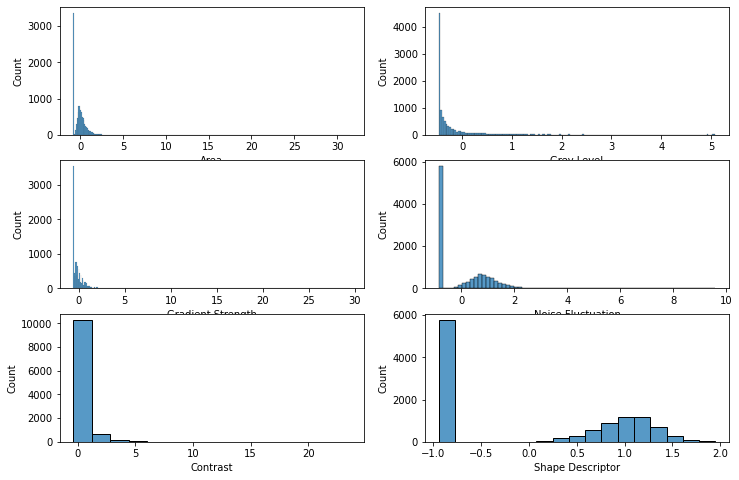

In [9]:
fig,ax=plt.subplots(3,2)
axes=ax.flatten()

for i,col in enumerate(data.columns[:-1]):
    sns.histplot(data[col],ax=axes[i]);

Input Features have different scales, exponential distribution.

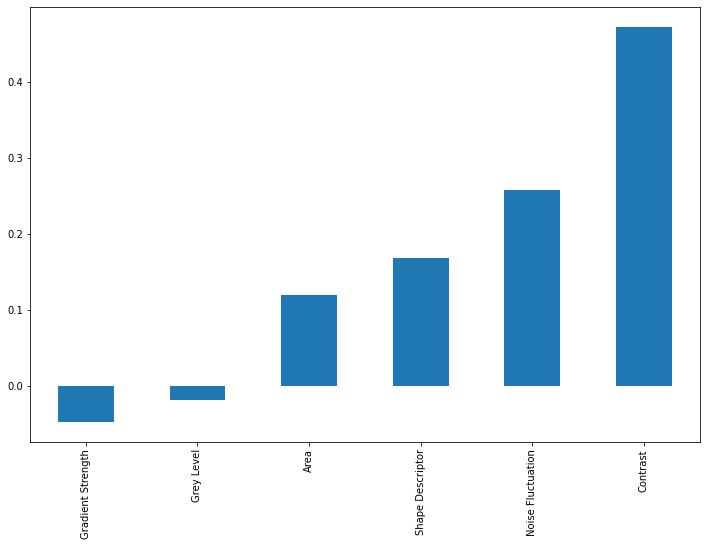

In [10]:
features=data.columns[:-1]

data[features].corrwith(data['Microcalcification']).sort_values().plot(kind='bar');

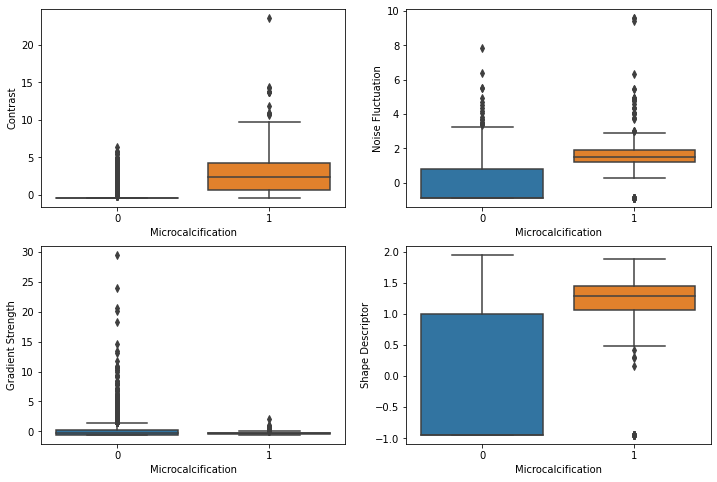

In [11]:
select=['Contrast','Noise Fluctuation','Gradient Strength','Shape Descriptor']
fig,ax=plt.subplots(2,2)
axes=ax.flatten()

for i,col in enumerate(select):
    sns.boxplot(x=data['Microcalcification'],y=data[col],ax=axes[i]);

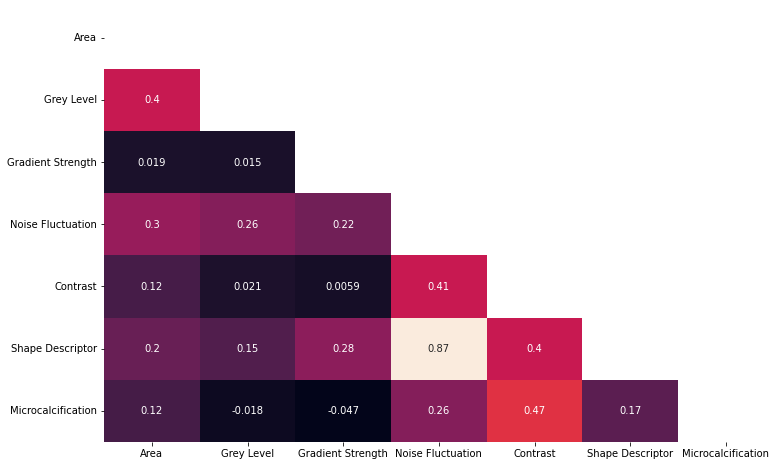

In [12]:
mask=np.triu(np.ones_like(data.corr()))

sns.heatmap(data.corr(),annot=True,mask=mask,cbar=False);

* Shape Descriptor and Noise Fluctuation(0.87)
* Constrast and Noise Fluctuation(0.41)
* Constrast and Shape Descriptor(0.40)
* Gradient Strength and Noise Fluctuation (0.22)
* Gradient Strength and Shape Descriptor (0.28)

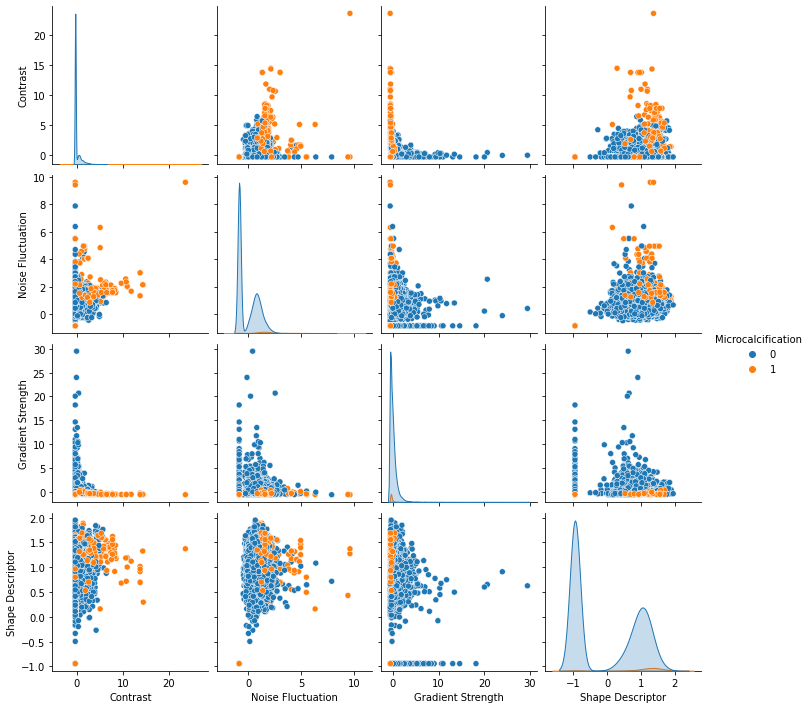

In [13]:
select=['Contrast','Noise Fluctuation','Gradient Strength','Shape Descriptor','Microcalcification']

sns.pairplot(data[select],hue='Microcalcification');

# Preprocessing

* Normalizing the dataset to have same range [0,1].
* Power transformation to make the distribution gaussian like.

In [14]:
X=data.drop('Microcalcification',axis=1)
y=data['Microcalcification']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,
                                                    random_state=42)

# Model Evaluation Function

In [16]:
def evaluate(X,y,model):
    cv=StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    scores=cross_val_score(model,X,y,cv=cv,scoring='roc_auc',n_jobs=-1)
    
    return scores

# Baseline Performance

Naive approach would to randomly predict class in proportion to class distribution.

In [17]:
model=DummyClassifier(strategy='stratified')

scores=evaluate(X_train,y_train,model)

print(f'\nAuc score for Dummy Classifier: {scores.mean()}, {scores.std()}')


Auc score for Dummy Classifier: 0.49983113693392306, 0.015932997004477187


# Algorithm Spot Checking

In [18]:
def get_models():
    models,names=list(),list()
    
    models.append(LogisticRegression())
    names.append('lr')
    
    models.append(SVC(probability=True))
    names.append('svc')
    
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('rf')
    
    return models,names

In [19]:
models,names=get_models()
results=list()

for i in range(len(models)):
    
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('m',models[i])]
    pipeline=Pipeline(steps=steps)
    
    scores=evaluate(X_train,y_train,pipeline)
    results.append(scores)
    
    print(f'\nAuc score for {names[i]}: {scores.mean()}, {scores.std()}')


Auc score for lr: 0.9117986347411435, 0.03714715840281329

Auc score for svc: 0.8744826993525947, 0.06339961959590013

Auc score for rf: 0.9404693880849843, 0.026312421323171527


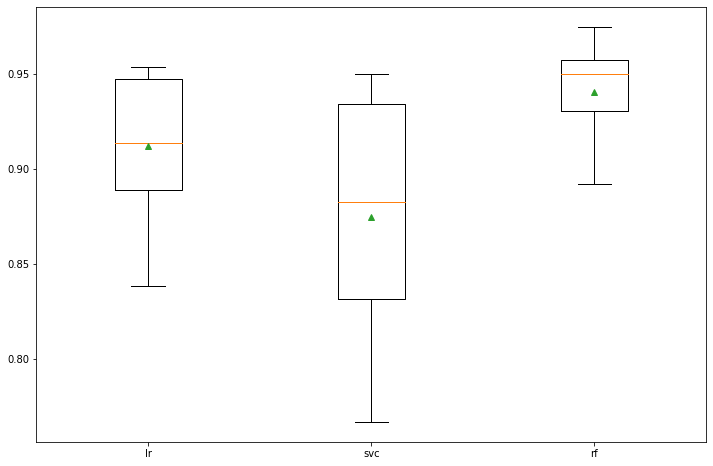

In [20]:
plt.boxplot(results,labels=names,showmeans=True);

# Data Sampling

Data sampling provides a collection of techniques that transform a training dataset in order to balance or better balance the class distribution. Once balanced, standard machine learning algorithms can be trained directly on the transformed dataset without any modification. This allows the challenge of imbalanced classification, even with severely imbalanced class distributions, to be addressed with a data preparation method.

In [21]:
def get_sampling():
    
    sampling,seq=list(),list()
    
    sampling.append(TomekLinks())
    seq.append('TL')
    
    sampling.append(EditedNearestNeighbours())
    seq.append('ENN')
    
    sampling.append(OneSidedSelection())
    seq.append('OSS')
    
    sampling.append(NeighbourhoodCleaningRule())
    seq.append('NCR')
    
    sampling.append(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')))
    seq.append('SMOTETomek')
    
    sampling.append(SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority')))
    seq.append('SMOTEENN')
    
    return sampling,seq

Auc score for TL: 0.9117748904983213, 0.03710340179518252
Auc score for ENN: 0.9118611821650344, 0.03716397743068382
Auc score for OSS: 0.9121844316453768, 0.03549106798492855
Auc score for NCR: 0.9104269673012155, 0.03781881962055259
Auc score for SMOTETomek: 0.9089410175670762, 0.03775410213408042
Auc score for SMOTEENN: 0.909911357344005, 0.0370484854198665





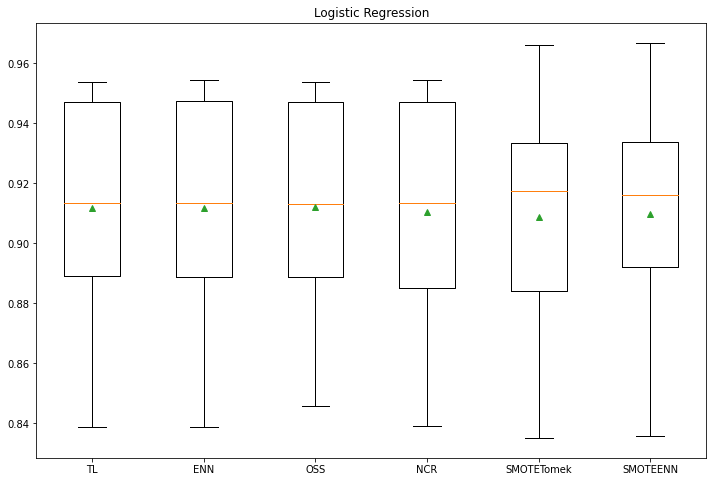

In [22]:
sampling,seq=get_sampling()
results=list()

for i in range(len(sampling)):
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('s',sampling[i]),('m',LogisticRegression())]
    pipeline=Pipeline(steps=steps)
        
    scores=evaluate(X_train,y_train,pipeline)
    results.append(scores)
        
    print(f'Auc score for {seq[i]}: {scores.mean()}, {scores.std()}')

print('\n\n')

plt.boxplot(results,labels=seq,showmeans=True);
plt.title("Logistic Regression");

Sampling does not results into performance increase in case of Logistic Regressor 

Auc score for TL: 0.8788857041003825, 0.06741494571200754
Auc score for ENN: 0.8919614895848117, 0.056490854555889036
Auc score for OSS: 0.8517310966918765, 0.09138136697661191
Auc score for NCR: 0.8949754737583536, 0.05275520530683952
Auc score for SMOTETomek: 0.9474357737438371, 0.024093859738487898
Auc score for SMOTEENN: 0.9487635977612741, 0.021194058028307938





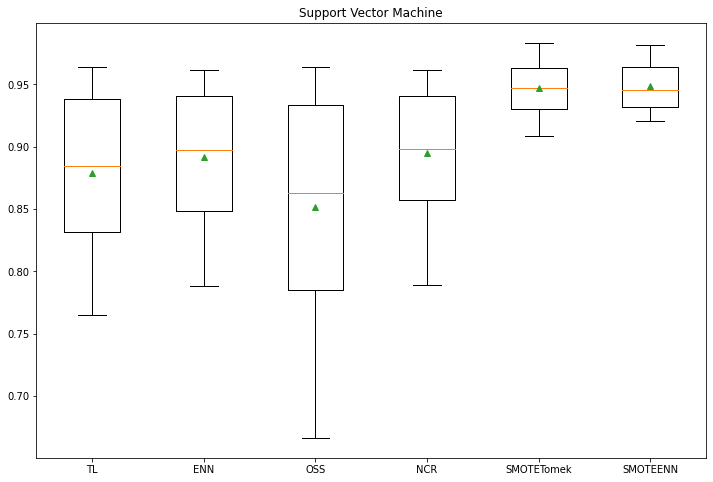

In [23]:
sampling,seq=get_sampling()
results=list()

for i in range(len(sampling)):
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('s',sampling[i]),('m',SVC(probability=True))]
    pipeline=Pipeline(steps=steps)
        
    scores=evaluate(X_train,y_train,pipeline)
    results.append(scores)
        
    print(f'Auc score for {seq[i]}: {scores.mean()}, {scores.std()}')

print('\n\n')

plt.boxplot(results,labels=seq,showmeans=True);
plt.title("Support Vector Machine");

Sampling(SMOTETomekand SMOTEENN) does results into performance increase in case of SVC

Auc score for TL: 0.9423561789952245, 0.027315234977528653
Auc score for ENN: 0.9405417594861202, 0.025586480135566043
Auc score for OSS: 0.8913380681708254, 0.07722286687207441
Auc score for NCR: 0.9405570100234399, 0.0212041380921829
Auc score for SMOTETomek: 0.9370568034147324, 0.026747992611597545
Auc score for SMOTEENN: 0.9371841551685378, 0.029589454821401302





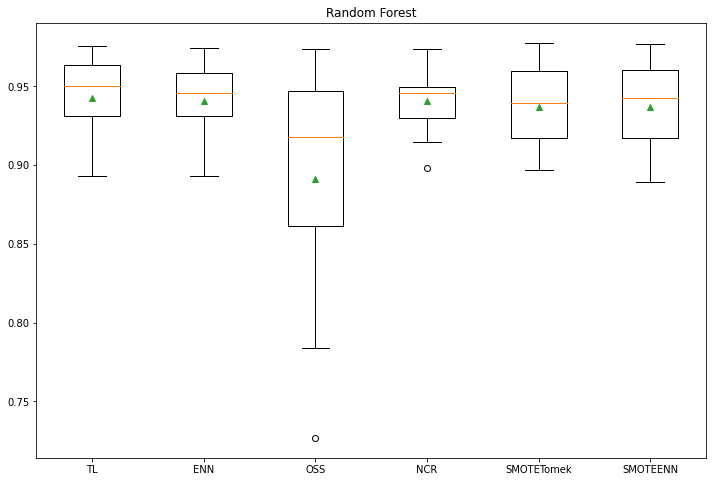

In [24]:
sampling,seq=get_sampling()
results=list()

for i in range(len(sampling)):
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('s',sampling[i]),('m',RandomForestClassifier(n_estimators=1000))]
    pipeline=Pipeline(steps=steps)
        
    scores=evaluate(X_train,y_train,pipeline)
    results.append(scores)
        
    print(f'Auc score for {seq[i]}: {scores.mean()}, {scores.std()}')

print('\n\n')

plt.boxplot(results,labels=seq,showmeans=True);
plt.title("Random Forest");

Sampling results into small performance increase in case of Random Forest and reducing standard deviation thereby increasing the reliablity.

# Cost Sensitive Learning

Most classifiers assume that the misclassification costs (false negative and false positive cost) are the same. In most real-world applications, this assumption is not true.

Real-world imbalanced binary classification problems typically have a different interpretation for each of the classification errors that can be made. For example, classifying a negative case as a positive case(non cancer patient as having cancer) is typically far less of a problem than classifying a positive case as a negative case(cancer patient as not having cancer).

In cost-sensitive learning instead of each instance being either correctly or incorrectly classified, each class (or instance) is given a misclassification cost. Thus, instead of trying to optimize the accuracy, the problem is then to minimize the total misclassification cost

In [25]:
def get_models():
    models,names=list(),list()
    
    models.append(LogisticRegression(class_weight='balanced'))
    names.append('lr')
    
    models.append(SVC(probability=True,class_weight='balanced'))
    names.append('svc')
    
    models.append(RandomForestClassifier(n_estimators=1000,class_weight='balanced'))
    names.append('rf')
    
    return models,names

In [26]:
models,names=get_models()
results=list()

for i in range(len(models)):
    
    steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('m',models[i])]
    pipeline=Pipeline(steps=steps)
    
    scores=evaluate(X_train,y_train,pipeline)
    results.append(scores)
    
    print(f'\nAuc score for {names[i]}: {scores.mean()}, {scores.std()}')


Auc score for lr: 0.9144439994602773, 0.038815142870317926

Auc score for svc: 0.9526999177184956, 0.01734454723894575

Auc score for rf: 0.9070884821683671, 0.03871848063211451


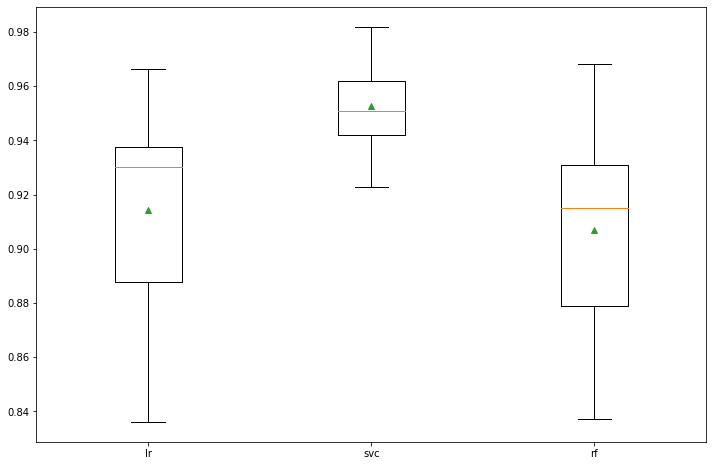

In [27]:
plt.boxplot(results,labels=names,showmeans=True);

Cost Sensitive Learning results into substanstial increase in svc performance.

# Model Selection

SVC with cost sensitive learning has result in best performance among all the predictors therefore we will be using Support Vector Classifier with cost sensitive learning.

Though model achieves good performance it can be further fine tuned using hyperparameter optimization.

Hyperparameter to tune
* C
* kernel
* gamma

In [28]:
model=SVC(probability=True,class_weight='balanced')

steps=[('t1',MinMaxScaler()),('t2',PowerTransformer()),('m',model)]
pipeline=Pipeline(steps=steps)

pipeline.fit(X_train,y_train)
y_probs=pipeline.predict_proba(X_test)[:,1]

In [29]:
fpr,tpr,thresholds=roc_curve(y_test,y_probs)
print(f'Area under precision_recall_curve: {roc_auc_score(y_test, y_probs)}')

Area under precision_recall_curve: 0.9817989790529836


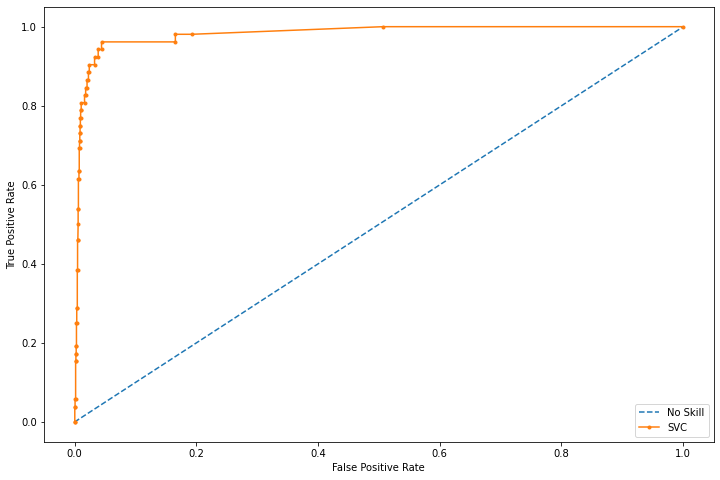

In [30]:
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill');
plt.plot(fpr, tpr, marker='.', label='SVC');

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Threshold Moving

In [31]:
g_means = np.sqrt(tpr*(1-fpr))
ix = np.argmax(g_means)
thresh=thresholds[ix]

print('Best Threshold=%f, g_means=%.3f' % (thresholds[ix], g_means[ix]))

Best Threshold=0.053873, g_means=0.959


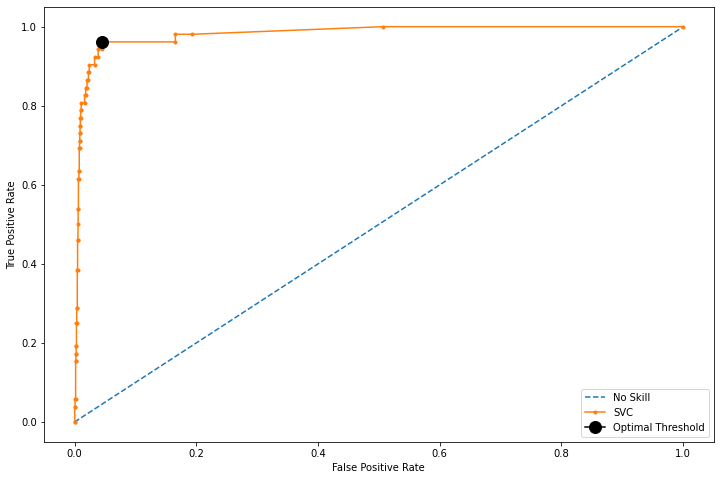

In [32]:
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill');
plt.plot(fpr, tpr, marker='.', label='SVC');
plt.plot(fpr[ix],tpr[ix],marker='o', markersize=12,color='black',label='Optimal Threshold');

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

In [33]:
y_pred=(y_probs>=thresh)

In [34]:
print(f'Classification_report: \n\n {classification_report(y_test,y_pred)}')

Classification_report: 

               precision    recall  f1-score   support

           0       1.00      0.96      0.98      2185
           1       0.34      0.96      0.50        52

    accuracy                           0.96      2237
   macro avg       0.67      0.96      0.74      2237
weighted avg       0.98      0.96      0.97      2237



In [35]:
val=['Non-Microclacification','Microclacification']
data=pd.DataFrame(confusion_matrix(y_test,y_pred),columns=val,index=val)

Text(50.99999999999999, 0.5, 'True Label')

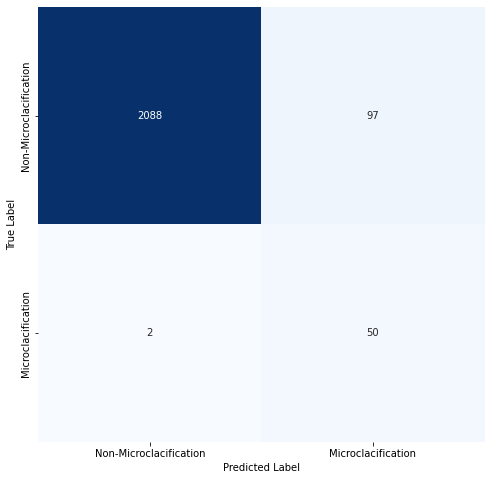

In [36]:
plt.figure(figsize=(8,8))

sns.heatmap(data,annot=True,cbar=False,cmap='Blues',fmt='g');
plt.xlabel('Predicted Label')
plt.ylabel('True Label')